In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.width', 500)
import csv
import sys
import time
import igraph as ig

In [19]:
def track_progess(total, progress, text='progress:', inc=1):
    a, b = progress, total
    perc = ((a+1) / b * 100)
    if a%inc == 0:
        print("\r {} {:_}/{:_} ({:.5f}%)".format( text, (a+1), b, perc ), end='')
    a += 1
    return a, perc

In [5]:
def get_tweets_dataframe():
    # Import dataset from tsv file
    dataset_fn = "../dataset/TweetsCOV19.tsv"
    header = ["Tweet Id", "Username", "Timestamp", "Followers", "Friends", "Retweets", "Favorites", "Entities", "Sentiment", "Mentions", "Hashtags", "URLs", "EXTRA"]
    dtype = {"Tweet Id":"string", "Username":"string", "Timestamp":"string", "Followers":int, "Friends":int, "Retweets":int, "Favorites":int, "Entities":"string", "Sentiment":"string", "Mentions":"string", "Hashtags":"string", "URLs":"string", "EXTRA":"string"}
    print("Importing dataset from tsv file ...", end='')
    start = time.time()
    df = pd.read_csv(dataset_fn, sep='\t', names=header, on_bad_lines='warn', dtype=dtype)
    end = time.time()
    print("read {:_} lines (took {:.1f}s)".format(len(df), end-start))
    df.set_index('Tweet Id', inplace=True)

    # Convert timestamp column to Timestamp object
    print("Converting timestamp column")
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%a %b %d %H:%M:%S %z %Y')

    # Filter columns and timestamp
    print("Filtering desired columns and between desired dates ... ", end='')
    dff = df[["Username", "Timestamp", "Sentiment", "Hashtags"]]
    start_date =    pd.to_datetime('2019-12-01 00:00:00 +0000')
    end_date =      pd.to_datetime('2020-03-01 00:00:00 +0000')
    dff = dff[(dff['Timestamp'] >= start_date) & (dff['Timestamp'] < end_date)]
    print("{:_} rows in dataframe".format(len(df)))

    # Parse hashtags tab into array
    print("Parsing hashtags and positive/negative sentiments")
    dff['Hashtags'] = dff['Hashtags'].str.split().apply(lambda x: [name for name in x if name != "null;"] if isinstance(x, list) else [])

    # Split positive and negative sentiments into own columns (and convert to int type)
    dff[['Sentiment_pos', 'Sentiment_neg']] = dff['Sentiment'].str.split(" ", expand=True)
    dff['Sentiment_pos'], dff['Sentiment_neg'] = dff['Sentiment_pos'].astype(int), dff['Sentiment_neg'].astype(int)
    dff.drop("Sentiment", axis=1, inplace=True)

    # Filter rows with mentions (and less that outlier mentions)
    print("filtering for tweets that contain hashtags ... ", end='')
    ht = dff[dff['Hashtags'].apply(lambda x: len(x) > 0 and len(x) < 60)]
    print("{:_} rows in dataframe".format(len(df)))

    return ht

In [3]:
def get_tweets_for_each_hashtag(df):
    array_col = "Hashtags"
    dicti = {}
    print("Getting list of ids per hashtag ...")
    i = 0
    for _, row in df.iterrows():
        i += 1
        perc = (i) / len(df) * 100
        print("\r {:_}/{:_} ({:.1f}%)".format(i, len(df), perc), end='')
        for term in set(row[array_col]):
            dicti[term] = dicti.get(term, []) + [row.name]
    print("\nDone.")
    print("Found {:_} unique hashtags".format(len(dicti)))
    # filter hashtags that have only 1 tweet (no edges created)
    dicti = { k: v for k, v in dicti.items() if len(v) > 1 }
    print("Found {:_} hashtags with more than 1 associated tweet".format(len(dicti)))
    return dicti

In [6]:
### BACK TO DATAFRAMES ###
df = get_tweets_dataframe()

Importing dataset from tsv file ...read 8_077_794 lines (took 61.1s)
Converting timestamp column
Filtering desired columns and between desired dates ... 8_077_794 rows in dataframe
Parsing hashtags and positive/negative sentiments
filtering for tweets that contain hashtags ... 8_077_794 rows in dataframe


In [7]:
# Get dictionary of hashtags with more than 1 tweet
ht_dict = get_tweets_for_each_hashtag(df)

Getting list of ids per hashtag ...
 462_901/462_901 (100.0%)
Done.
Found 292_264 unique hashtags
Found 81_269 hashtags with more than 1 associated tweet
81269


In [21]:
g = nx.Graph()
g.add_nodes_from(list(ht_dict.keys()))
rows_handled, total = 0, len(df)
for _, row in df.iterrows():
    ht = [ht for ht in row['Hashtags'] if ht in ht_dict]
    for i in range(len(ht)):
        for j in range(i+1, len(ht)):
            g.add_edge(ht[i], ht[j])
    rows_handled, perc = track_progess(total, rows_handled, inc=25)
print("\nDone.")
print(g)

 progress: 462_901/462_901 (100.00000%)Graph with 81269 nodes and 815141 edges


In [30]:
ccs = nx.connected_components(g)
ccs = sorted(list(ccs), reverse=True, key=lambda cc: len(cc))
print("amount of components is {:_}".format(len(ccs)))
for i in range(10):
    print(len(ccs[i]))

amount of components is 7_746
71895
14
13
13
13
12
12
11
11
10


In [65]:
ht_component = ccs[0]
if len(ht_component) < 100:
    print(ht_component)
component = []
for ht in ht_component:
    for id in ht_dict[ht]:
        component.append(id)
print(len(set(component)))

385468


Graph with 5 nodes and 10 edges


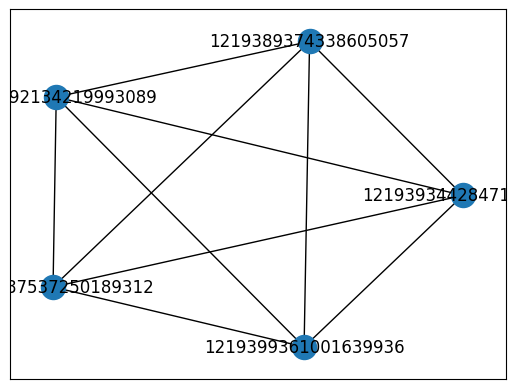

In [59]:
gs = nx.Graph()
for ht in ht_component:
    ids = ht_dict[ht]
    #print(ids)
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            gs.add_edge(ids[i], ids[j])
print(gs)

import networkx as nx
import matplotlib.pyplot as plt
nx.draw_networkx(gs)
plt.show()